In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

## Loading Data and Initial Inspections
Loaded in the [Insect Species Occurrence Data from Multiple Projects Worldwide with Focus on Bees and Wasps in North America](https://www.gbif.org/dataset/f519367d-6b9d-411c-b319-99424741e7de#description) dataset. I chose this dataset since I'm passionate about all things bees and a large portion of the insects within this dataset are bees. Initial inspections reveal an huge amount of data nearly 600,000 entries and many entirely null columns or columns that are useless for analysis. I proceed to remove those null columns and those that provide no value to the analysis/exploritory process.

In [2]:
df = pd.read_csv('Downloads/bee_data.csv', sep='\t', on_bad_lines='skip')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582171 entries, 0 to 582170
Data columns (total 50 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   gbifID                            582171 non-null  int64  
 1   datasetKey                        582171 non-null  object 
 2   occurrenceID                      582171 non-null  object 
 3   kingdom                           582171 non-null  object 
 4   phylum                            582167 non-null  object 
 5   class                             582163 non-null  object 
 6   order                             541576 non-null  object 
 7   family                            541212 non-null  object 
 8   genus                             540485 non-null  object 
 9   species                           470329 non-null  object 
 10  infraspecificEpithet              0 non-null       float64
 11  taxonRank                         582171 non-null  o

In [3]:
df_clean = df.drop([
        # Null columns
        'infraspecificEpithet', 'verbatimScientificNameAuthorship', 'coordinateUncertaintyInMeters', 'elevation', 'elevationAccuracy', 
        'depth', 'depthAccuracy', 'recordNumber', 'rightsHolder', 'typeStatus', 'establishmentMeans', 'mediaType',
        # Not useful columns
        'gbifID', 'datasetKey', 'occurrenceID', 'taxonRank', 'publishingOrgKey', 'taxonKey', 'speciesKey', 'basisOfRecord', 'institutionCode',
        'collectionCode', 'catalogNumber', 'identifiedBy', 'license', 'recordedBy', 'lastInterpreted', 'issue'
    ], axis=1)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582171 entries, 0 to 582170
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   kingdom                 582171 non-null  object 
 1   phylum                  582167 non-null  object 
 2   class                   582163 non-null  object 
 3   order                   541576 non-null  object 
 4   family                  541212 non-null  object 
 5   genus                   540485 non-null  object 
 6   species                 470329 non-null  object 
 7   scientificName          582171 non-null  object 
 8   verbatimScientificName  582171 non-null  object 
 9   countryCode             582115 non-null  object 
 10  locality                526055 non-null  object 
 11  stateProvince           576598 non-null  object 
 12  occurrenceStatus        582171 non-null  object 
 13  individualCount         582171 non-null  int64  
 14  decimalLatitude     

## Data Exploration
Now that the data has been wrangled, some of the more interesting columns can be analyzed a bit more to see what value they might provide. This dataset has a lot of taxonomy classification information, so I plot those classifications to determine which level might provide insight into potential uses for this data.

There are dominant imbalances between all classes across the data. I'm concerned with the idea of including species with very few observations. I'm not sure any meaningful conclusions can be determined from so few instances. To remede this concern, I can always select for all species above a specific threshold or select the top `n` species. Subselecting for species will also address training time concerns if that becomes an issue with my chosen approach.

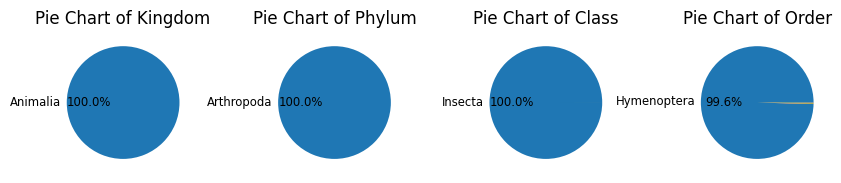

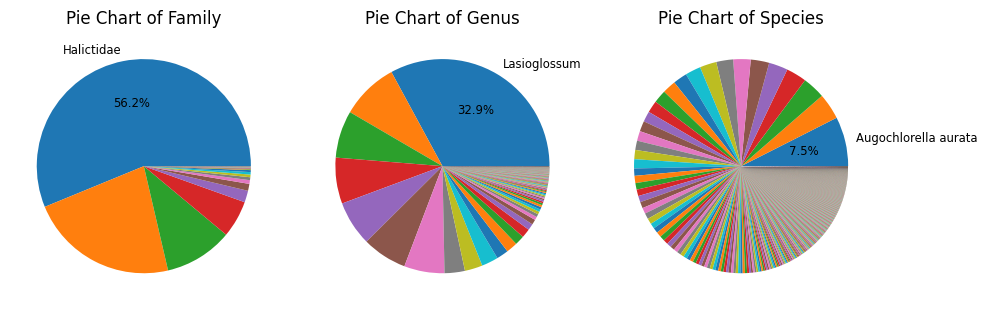

In [4]:
def pie_plot_column(col, df=df_clean, axs=None):
    counts = df[col].value_counts().dropna()

    largest_value = counts.values.max()
    largest_label = counts.index[np.where(counts.values == largest_value)[0]][0]
    
    labels_list = [label if label == largest_label else "" for label in counts.index.tolist()]
    if axs is None:
        plt.pie(
            counts.values.tolist(),
            labels=labels_list,
            autopct=lambda p: f'{p:.1f}%' if math.isclose(p, (largest_value / counts.values.sum()) * 100, rel_tol=1e-3) else '',
            textprops={'size': 'smaller'})
        plt.title(f"Pie Chart of {col.capitalize()}")
    else:
        axs.pie(
            counts.values.tolist(),
            labels=labels_list,
            autopct=lambda p: f'{p:.1f}%' if math.isclose(p, (largest_value / counts.values.sum()) * 100, rel_tol=1e-3) else '',
            textprops={'size': 'smaller'})
        axs.set_title(f"Pie Chart of {col.capitalize()}")

# Plot dominanting taxonomy classifications
fig, axs = plt.subplots(1, 4, figsize=(10, 2))
plt.subplots_adjust(wspace=.5)
for i, col in enumerate(['kingdom', 'phylum', 'class', 'order']):
    pie_plot_column(col, axs=axs[i])

# Plot mixed taxonomy classifications
fig, axs = plt.subplots(1, 3, figsize=(10, 8))
for i, col in enumerate(['family', 'genus', 'species']):
    pie_plot_column(col, axs=axs[i])

fig.tight_layout()
plt.show()

## Data Exploration
#### Inspect DataFrame for columns that doesn't look complete and might need to be processed or groomed.

Conduting the same spirit of analyzing as I did with taxonomy classification, location data is broken down. Countrycode is dominanted by data gathered in the US and there is a great deal of dispersion for the Locality attribute. State province is somewhat concerning with how much of the data is gathered from Maryland, but the distribution isn't so extreme it can't be mitigated.

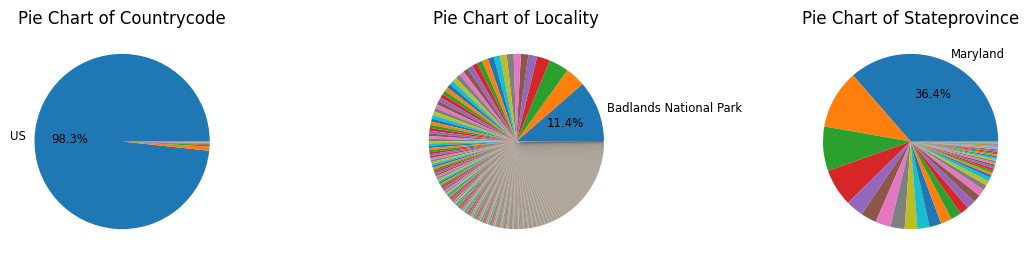

In [5]:
# Plot location attributes
fig, axs = plt.subplots(1, 3, figsize=(13, 8))
plt.subplots_adjust(wspace=.8)
for i, col in enumerate(['countryCode', 'locality', 'stateProvince']):
    pie_plot_column(col, axs=axs[i])

plt.show()

### Preprocessing
Important preprocessing to enable continued exploration is converting the `eventDate` column from a `string` to a `pd.Timestamp`. This consists of isolating the start date/time of the event, converting it to our desired data type, and finally remove all formats that couldn't be converted.

Proceed to analyze the data by the newly created `date` column across all possible date metrics: year, month, day, etc.

In [6]:
def convert_date(date_string):
    if isinstance(date_string, str) and '/' in date_string:
        first_date = date_string.split('/')[0]
        return first_date.split('T')[0]
    elif isinstance(date_string, str) and 'T' in date_string:
        return date_string.split('T')[0]
    return None

df_clean.dropna(subset=['eventDate'], inplace=True)
df_clean = df_clean.assign(date = pd.to_datetime(df_clean['eventDate'].apply(convert_date)))
df_clean = df_clean.dropna(subset=['date'])

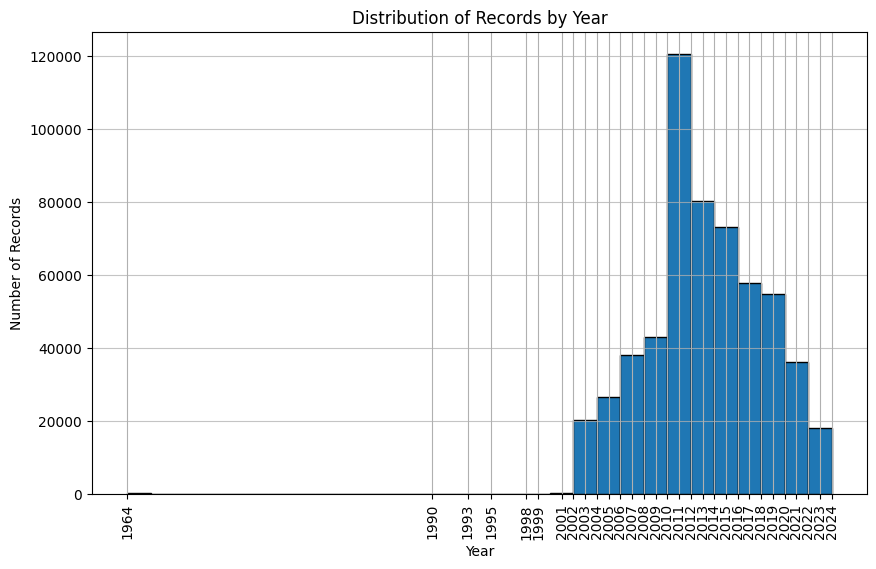

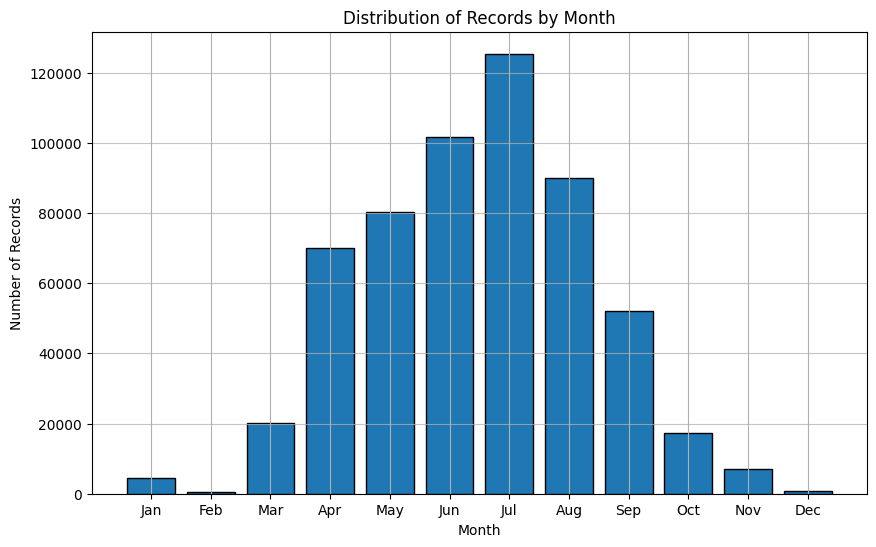

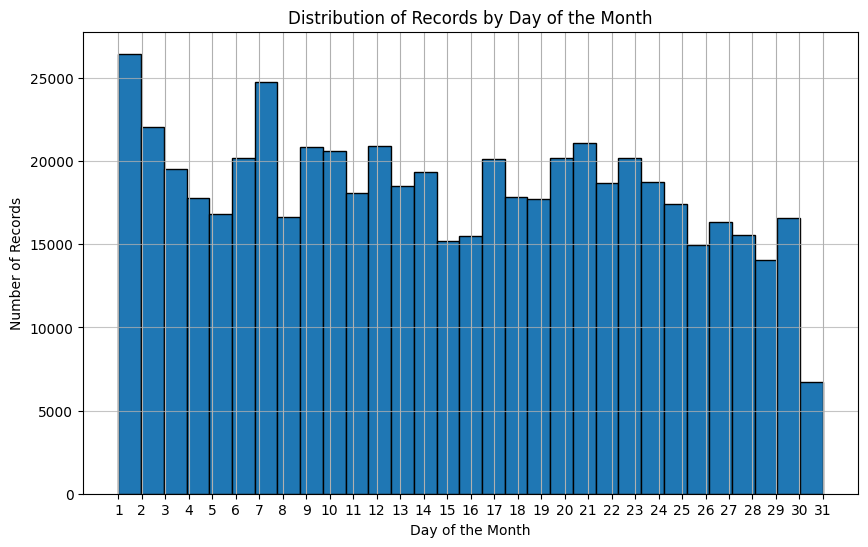

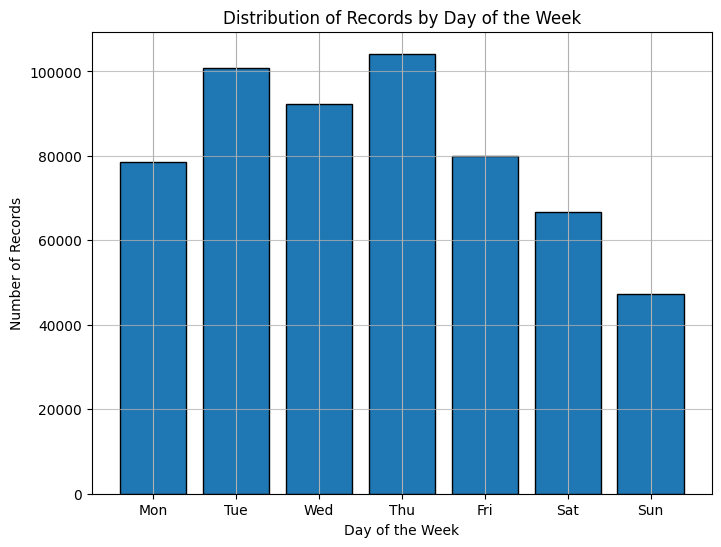

In [7]:
def analyze_dates(df=df, logs=False, plot=True):
    first_date = df['date'].min()
    last_date = df['date'].max()

    # Distribution by Year, Month, Day of Month, and Day of Week
    yearly_counts = df['date'].dt.year.value_counts().sort_index()
    monthly_counts = df['date'].dt.month.value_counts().sort_index()
    month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                   7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    monthly_counts.index = monthly_counts.index.map(month_names)
    day_of_month_counts = df['date'].dt.day.value_counts().sort_index()
    day_of_week_counts = df['date'].dt.dayofweek.value_counts().sort_index()
    day_names = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
    day_of_week_counts.index = day_of_week_counts.index.map(day_names)

    if logs: 
        print(f"First recorded date: {first_date}")
        print(f"Last recorded date: {last_date}")
        
        print("\nDistribution of records by year:")
        print(yearly_counts)

        print("\nDistribution of records by month:")
        print(monthly_counts)
        
        print("\nDistribution of records by day of the month:")
        print(day_of_month_counts)
    
        print("\nDistribution of records by day of the week:")
        print(day_of_week_counts)
        
    if plot:
        # Yearly distribution
        plt.figure(figsize=(10, 6))
        df['date'].dt.year.hist(bins=yearly_counts.index.nunique(), edgecolor='black')
        plt.title('Distribution of Records by Year')
        plt.xlabel('Year')
        plt.ylabel('Number of Records')
        plt.xticks(yearly_counts.index)
        plt.grid(axis='y', alpha=0.75)
        plt.xticks(rotation=90)
        plt.show()
        
        # Monthly distribution
        plt.figure(figsize=(10, 6))
        df['date'].dt.month.hist(bins=range(1, 14), align='left', rwidth=0.8, edgecolor='black')
        plt.title('Distribution of Records by Month')
        plt.xlabel('Month')
        plt.ylabel('Number of Records')
        plt.xticks(range(1, 13), month_names.values())
        plt.grid(axis='y', alpha=0.75)
        plt.show()
        
        # Day of month distribution
        plt.figure(figsize=(10, 6))
        df['date'].dt.day.hist(bins=31, range=(1, 31), edgecolor='black')
        plt.title('Distribution of Records by Day of the Month')
        plt.xlabel('Day of the Month')
        plt.ylabel('Number of Records')
        plt.xticks(range(1, 32))
        plt.grid(axis='y', alpha=0.75)
        plt.show()
        
        # Day of week distribution
        plt.figure(figsize=(8, 6))
        df['date'].dt.dayofweek.hist(bins=range(8), align='left', rwidth=0.8, edgecolor='black')
        plt.title('Distribution of Records by Day of the Week')
        plt.xlabel('Day of the Week')
        plt.ylabel('Number of Records')
        plt.xticks(range(7), day_names.values())
        plt.grid(axis='y', alpha=0.75)
        plt.show()
    
analyze_dates(df_clean, logs=False, plot=True)

The data is largely clustered between 2002 and 2024, specifically, the data has the largest collect in 2011 with 75,007 records and 2012 with 52110 records. Another noteworthy observation is that the vast majority of data entries were conducted in the summer months around July and June. Thus, I will restrict the data to years after 2002 to ensure there is enough data to make meaningful conclusions about a more selective timeframe.

In [8]:
df_cleaned = df_clean[df_clean['date'].dt.year >= 2002]
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 569089 entries, 0 to 582170
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   kingdom                 569089 non-null  object        
 1   phylum                  569085 non-null  object        
 2   class                   569081 non-null  object        
 3   order                   529398 non-null  object        
 4   family                  529037 non-null  object        
 5   genus                   528309 non-null  object        
 6   species                 460460 non-null  object        
 7   scientificName          569089 non-null  object        
 8   verbatimScientificName  569089 non-null  object        
 9   countryCode             569041 non-null  object        
 10  locality                514488 non-null  object        
 11  stateProvince           563831 non-null  object        
 12  occurrenceStatus        569089 non-

## Analysis Methods
There are a lot of analysis options with this data and different approaches questions that could be answered. The question I decided upon was: Where are species likely to be found absed on environmental factors and the existing occurrence records? The entire dataset is precense/occurrence data with latitude and longitude. Naturally, I suspected this dataset wouldn't be rich enough on its own as it lack environmental data such as temperatures, precipitation, etc. After doing some research, I selected a method known as [MaxEnt](https://biodiversityinformatics.amnh.org/open_source/maxent/) which stands for Maximum Entropy. This approach seems to be a prefect match for this dataset. MaxEnt is designed to take in environmental grid data across a region. Since the dataset provide latitude and longitude values the model should be able to map occurrence records with the environmental data that is incorporated into the model. The way the model works with presence-only data is by generating implied absence data from the dataset. It does this with methods that up and down sample according to how imbalanced different classes and attributes are so this should help midigate the concerns from `species` and `stateProvince`.

## Train and Test Datasets
Now that the data has been cleaned and the modeling alogrithm has been selected train and test DataFrames can be constructed and exported. Below, I create a couple of different training and testing sets, but different selections can be made to answer different questions. I just create one that trims a couple states which I couldn't find the desired environmental layers data on, and another pair of datasets that selects on the top 10 species. 

In [15]:
# Rename columns for easier auto detection by MaxEnt
df = df.rename(columns={'decimalLatitude': 'latitude', 'decimalLongitude': 'longitude'})

# Restrict timeframe between 2002-2024
df = df[df['Year'] >= 2002]

# Select for US states given specific environmental layers data
us_states_subset = [
    # Wasn't able to find environmental layers data that supported these locations:
    # 'Alaska', 'California', 'Florida', 'Hawaii', 'Maine', 'New York', 
    'Alabama', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut', 'Delaware', 'Georgia', 'Idaho', 'Illinois', 'Indiana', 
    'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 
    'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'North Carolina', 'North Dakota',
    'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 
    'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming',
]
df_sub_states = df[df['stateProvince'].isin(us_states_subset)]

# Select for top 10 species occurrences within the dataset 
top_10_species = [
    'Augochlorella aurata',
    'Lasioglossum pilosum',
    'Bombus impatiens',
    'Agapostemon splendens',
    'Lasioglossum versatum',
    'Halictus tripartitus',
    'Andrena erigeniae',
    'Apis mellifera',
    'Agapostemon virescens',
    'Ceratina calcarata']
df_sub_species = df_sub_states[df_sub_states['species'].isin(top_10_species)]

# Remove bloated columns for easier feature detection by MaxEnt (only needs species, latitude, and longitude)
removing = [
    'gbifID', 'datasetKey', 'occurrenceID', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'infraspecificEpithet',
    'taxonRank', 'scientificName', 'verbatimScientificName', 'verbatimScientificNameAuthorship', 'countryCode', 'locality',
    'stateProvince', 'occurrenceStatus', 'individualCount', 'publishingOrgKey','coordinateUncertaintyInMeters', 
    'coordinatePrecision', 'elevation', 'elevationAccuracy', 'depth', 'depthAccuracy', 'eventDate', 'day','month', 'year', 
    'taxonKey', 'speciesKey', 'basisOfRecord', 'institutionCode', 'collectionCode', 'catalogNumber', 'recordNumber',
    'identifiedBy', 'dateIdentified', 'license', 'rightsHolder', 'recordedBy', 'typeStatus', 'establishmentMeans', 'lastInterpreted',
    'mediaType', 'issue'
]

df_sub_states = df_sub_states.drop(removing, axis=1)
df_sub_states = df_sub_states.dropna()

df_sub_species = df_sub_species.drop(removing, axis=1)
df_sub_species = df_sub_species.dropna()

# Split and export DataFrames to csv
train_df, test_df = train_test_split(df_sub_states, test_size=.2)
train_df.to_csv('maxent_data_full_train.csv', index=False)
test_df.to_csv('maxent_data_full_test.csv', index=False)
print(f"Full data train and test shape: {train_df.shape}, {test_df.shape}")

train_df, test_df = train_test_split(df_sub_species, test_size=.2)
train_df.to_csv('maxent_data_10_species_train.csv', index=False)
test_df.to_csv('maxent_data_10_species_test.csv', index=False)
print(f"Top 10 Species data train and test shape: {train_df.shape}, {test_df.shape}")

Full data train and test shape: (331347, 3), (82837, 3)
Top 10 Species data train and test shape: (116869, 3), (29218, 3)


## Running MaxEnt
I ran MaxEnt a variety of times on a variety of datasets. MaxEnt can be configured to run with or without a test dataset through the settings modal. When starting MaxEnt memory can be allocated to the program. Many of the runs with the full or majority of the environmental layer data selected resulted in my machine crashing because of memory heap issues, thus my final runs selected a couple of different years from both the precipitation and average temperature environmental data. The years I selected for the results pushed to my GitHub project where 2011 and 2013 for each respective environment type. It seems from my testing the memory issues become much more prevalent depending on how many environment layers you select rather than how many species are input.

## Conclusions
The results of the MaxEnt program were fantastic. Working with a new algorithm always makes me nervous, but I was astonished by the accuracy and ability for the algorithm to get an amazingly high AUC on both the train and test sets. For the full analysis including all species my suspicions about underperformance on species with few data entires was confirmed. MaxEnt even raised warnings that I suppressed about species that weren't included in the test set (if a species has one record it can't be in both the train and test set). Consequently, the accuracy for those species was either perfect or poor. That caveat being said, for all the species with a decent amount of data the performance was easily more than I could ask for with many instances reaching over 99% AUC. The output of the MaxEnt model is incredibly extensive consisting of html pages with full analysis on each species, plots of the US where that species was observed and predicted to exist, the ROC and AUC plots for each species, and finally an overall summary stored in `maxentResults.csv`. Based on the pure volume of results data I strongly encourage the reader to look around at a couple of the files to begin to truly understand the vast amount of information MaxEnt provides.

#### Pictures of the model
The receiver operating characteristic (ROC) curve for the Augochlorella_aurata. Note that the specificity is defined using predicted area, rather than true commission (see the paper by Phillips, Anderson and Schapire cited on the help page for discussion of what this means). This implies that the maximum achievable AUC is less than 1. If test data is drawn from the Maxent distribution itself, then the maximum possible test AUC would be 0.925 rather than 1; in practice the test AUC may exceed this bound. 
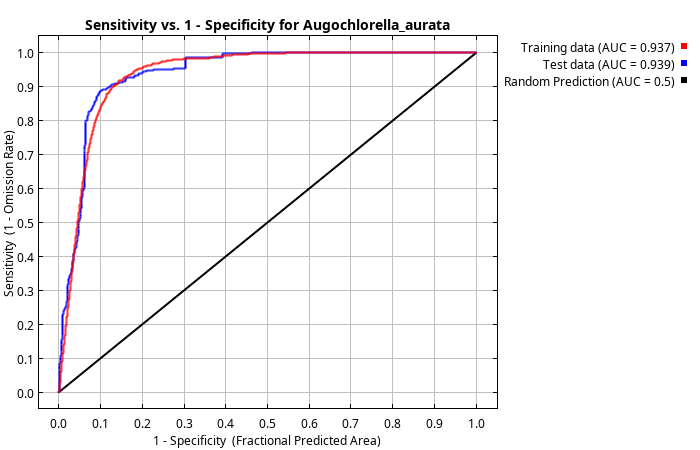


This is a representation of the Maxent model for Augochlorella_aurata. Warmer colors show areas with better predicted conditions. White dots show the presence locations used for training, while violet dots show test locations.
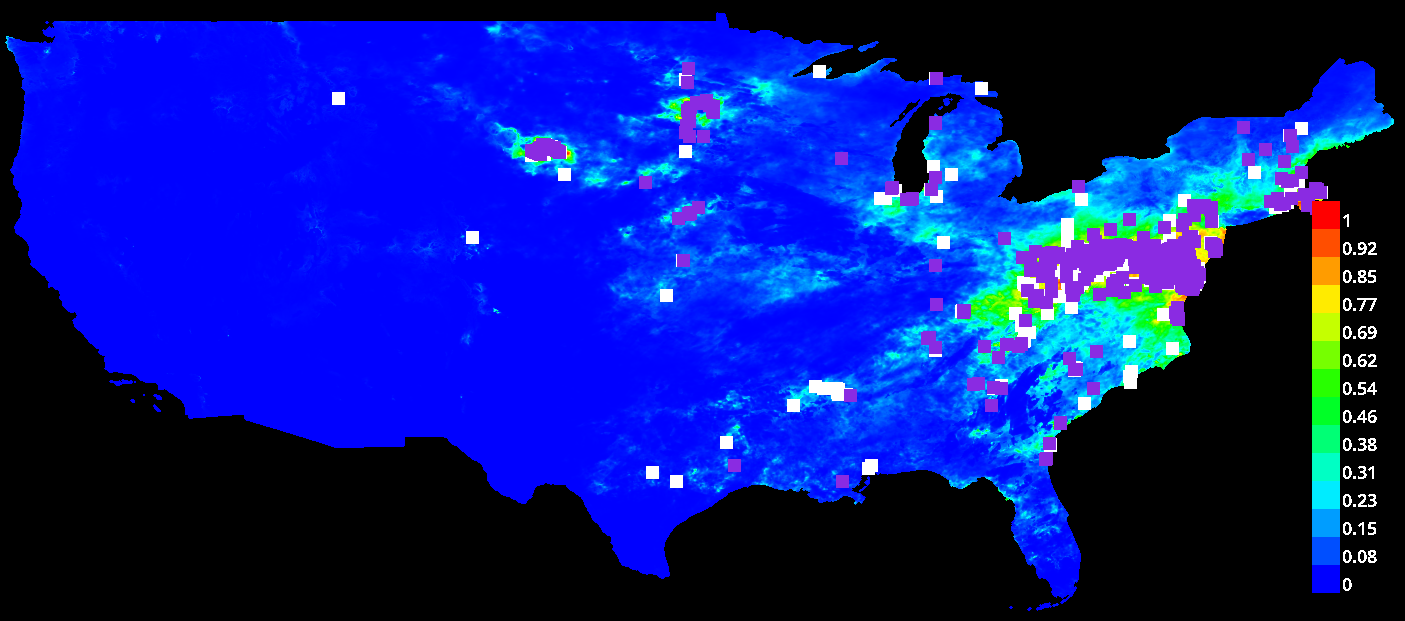

## Future Work
I tried to add ample documentation to my GitHub project so that anyone can clone this repository and investigate the results I have already run and even expand on my analysis with new train and test data or even new environmental layer combinations. Personally, I would be curious to average some of the environmental layer data to create environmental layer data periods. Training a MaxEnt model on each of these periods and comparing the data could provide insight into habitat sustainability over time impacted by long term impacts such as climate change. This analysis could reveal how bee and insect habitats are changing and adapting over larger swaths of time. By leveraging a mapping tool such as QGIS contrasting the habitat maps between periods could lead to some pretty graphics and interesting conclusions.

## Citations
- Droege S, Maffei C (2025). Insect Species Occurrence Data from Multiple Projects Worldwide with Focus on Bees and Wasps in North America. Version 1.25. United States Geological Survey. Sampling event dataset https://doi.org/10.15468/6autvb accessed via GBIF.org on 2025-04-27. 
- PRISM Group, Oregon State University, https://prism.oregonstate.edu, data created 4 Feb 2024, accessed 24 Apr 2025.